In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from utils.utils_train import train_supervised, train_models_in_threads, test_model
from utils.utils_plots import plot_first_feature
from utils.utils_dataset import balance_dataset, prepare_dataset
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc
#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)
'''
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
'''

"\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Select the columns to normalize - all except 'Class'\ncols_to_normalize = [col for col in data.columns if col != 'Class']\n\n# Apply the normalization\ndata[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])\n"

In [4]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 2,
    "S_0": 1e-10,
    "N_r": 1,
    "c_max": 100,
    "num_samples": 100,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 5,
    "S_0": 1e-10,
    "N_r": 1,
    "c_max": 30,
    "num_samples": 100,
    "device": device
}

In [6]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [7]:

import cProfile
%load_ext line_profiler


#plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  



In [8]:
if False:
       data, labels = client_train[0]
       model = local_models[0]

       %lprun -f model.forward\
              -f model.merging_mech.compute_kappa_matrix \
              -f model.merging_mech.merging_mechanism \
              -f model.merging_mech.update_merging_condition \
              -f model.merging_mech.compute_merging_condition\
              -f model.merging_mech.perform_merge\
              train_supervised(model, client_train[0])

In [9]:
def run_experiment(num_clients, num_rounds, clients_data, test_data):
        
    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []

    if False:
        # Assuming models and client_data are already defined
        #for client_idx, client_model in enumerate(local_models)
        model = local_models[0]
        pr = cProfile.Profile()
        pr.enable()
        train_supervised(model, client_train[0])
        pr.disable()
        pr.print_stats(sort='cumtime')

    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")

        agreggated_model = eGAUSSp(**federated_model_params)
            
        # Train local models
        #train_models_in_threads(local_models, clients_data)
        for local_model, client_data in zip(local_models, clients_data):
            train_supervised(local_model, client_data)
        
        # Update federated model with local models
        for client_idx, client_model in enumerate(local_models):
            print(f"Updating agreggated model with client {client_idx + 1}")
            agreggated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)
            print(f"Number of agreggated clusters after transfer = {sum(agreggated_model.n[0:agreggated_model.c]> agreggated_model.kappa_n)}")
            print(f"Number of agreggated clusters after merging = {sum(agreggated_model.n[0:agreggated_model.c]> agreggated_model.kappa_n)}")
            agreggated_model.federal_agent.federated_merging()
            
        with torch.no_grad():
            agreggated_model.S = nn.Parameter(agreggated_model.S/num_clients)
            agreggated_model.n = nn.Parameter(agreggated_model.n/num_clients)

            agreggated_model.S_glo = agreggated_model.S_glo/num_clients
            agreggated_model.n_glo = agreggated_model.n_glo/num_clients

        # Update federated model with local models
        print(f"Updating federated model with agreggated model")
        federated_model.federal_agent.merge_model_privately(agreggated_model, federated_model.kappa_n)
        print(f"Number of federated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")
        federated_model.federal_agent.federated_merging()
           
        #client_model.score = 0*client_model.score  
        #client_model.S = client_model.S/2
        with torch.no_grad():
            federated_model.S = nn.Parameter(federated_model.S/2)
            federated_model.n = nn.Parameter(federated_model.n/2)

            federated_model.S_glo = federated_model.S_glo/2
            federated_model.n_glo = federated_model.n_glo/2

        print(f"Number of federated clusters after merging = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

        # Perform federated merging and removal mechanism on the federated model
        if any(federated_model.n[0:federated_model.c]> federated_model.kappa_n):

            # Evaluate federated model
            all_scores, pred_max, _ = test_model(federated_model, test_data)
            binary = calculate_metrics(pred_max, test_data, "binary")
            weighted = calculate_metrics(pred_max, test_data, "weighted")
            roc_auc = calculate_roc_auc(all_scores, test_data)
            print(f"Test Metrics: {binary}")
            print(f"Test ROC AUC: {roc_auc}")

            plot_confusion_matrix(pred_max, test_data)

            # Append metrics to the list
            round_metrics.append({
                'round': round + 1,
                'clusters': federated_model.c,
                'binary': binary,
                'weighted': weighted,
                'roc_auc': roc_auc
            })

            # Return the updated federated model to each client
            for client_idx, client_model in enumerate(local_models):
                print(f"Returning updated model to client {client_idx + 1}")
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
                client_model.federal_agent.federated_merging()
            
            print(f"--- End of Round {round + 1} ---\n")
        
        
        plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max = federated_model.kappa_n)   
    
    # After all rounds
    print("All Rounds Completed. Metrics Collected:")
    for metric in round_metrics:
        print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
        #print(f"                         Weighted: {metric['weighted']}")


    return round_metrics

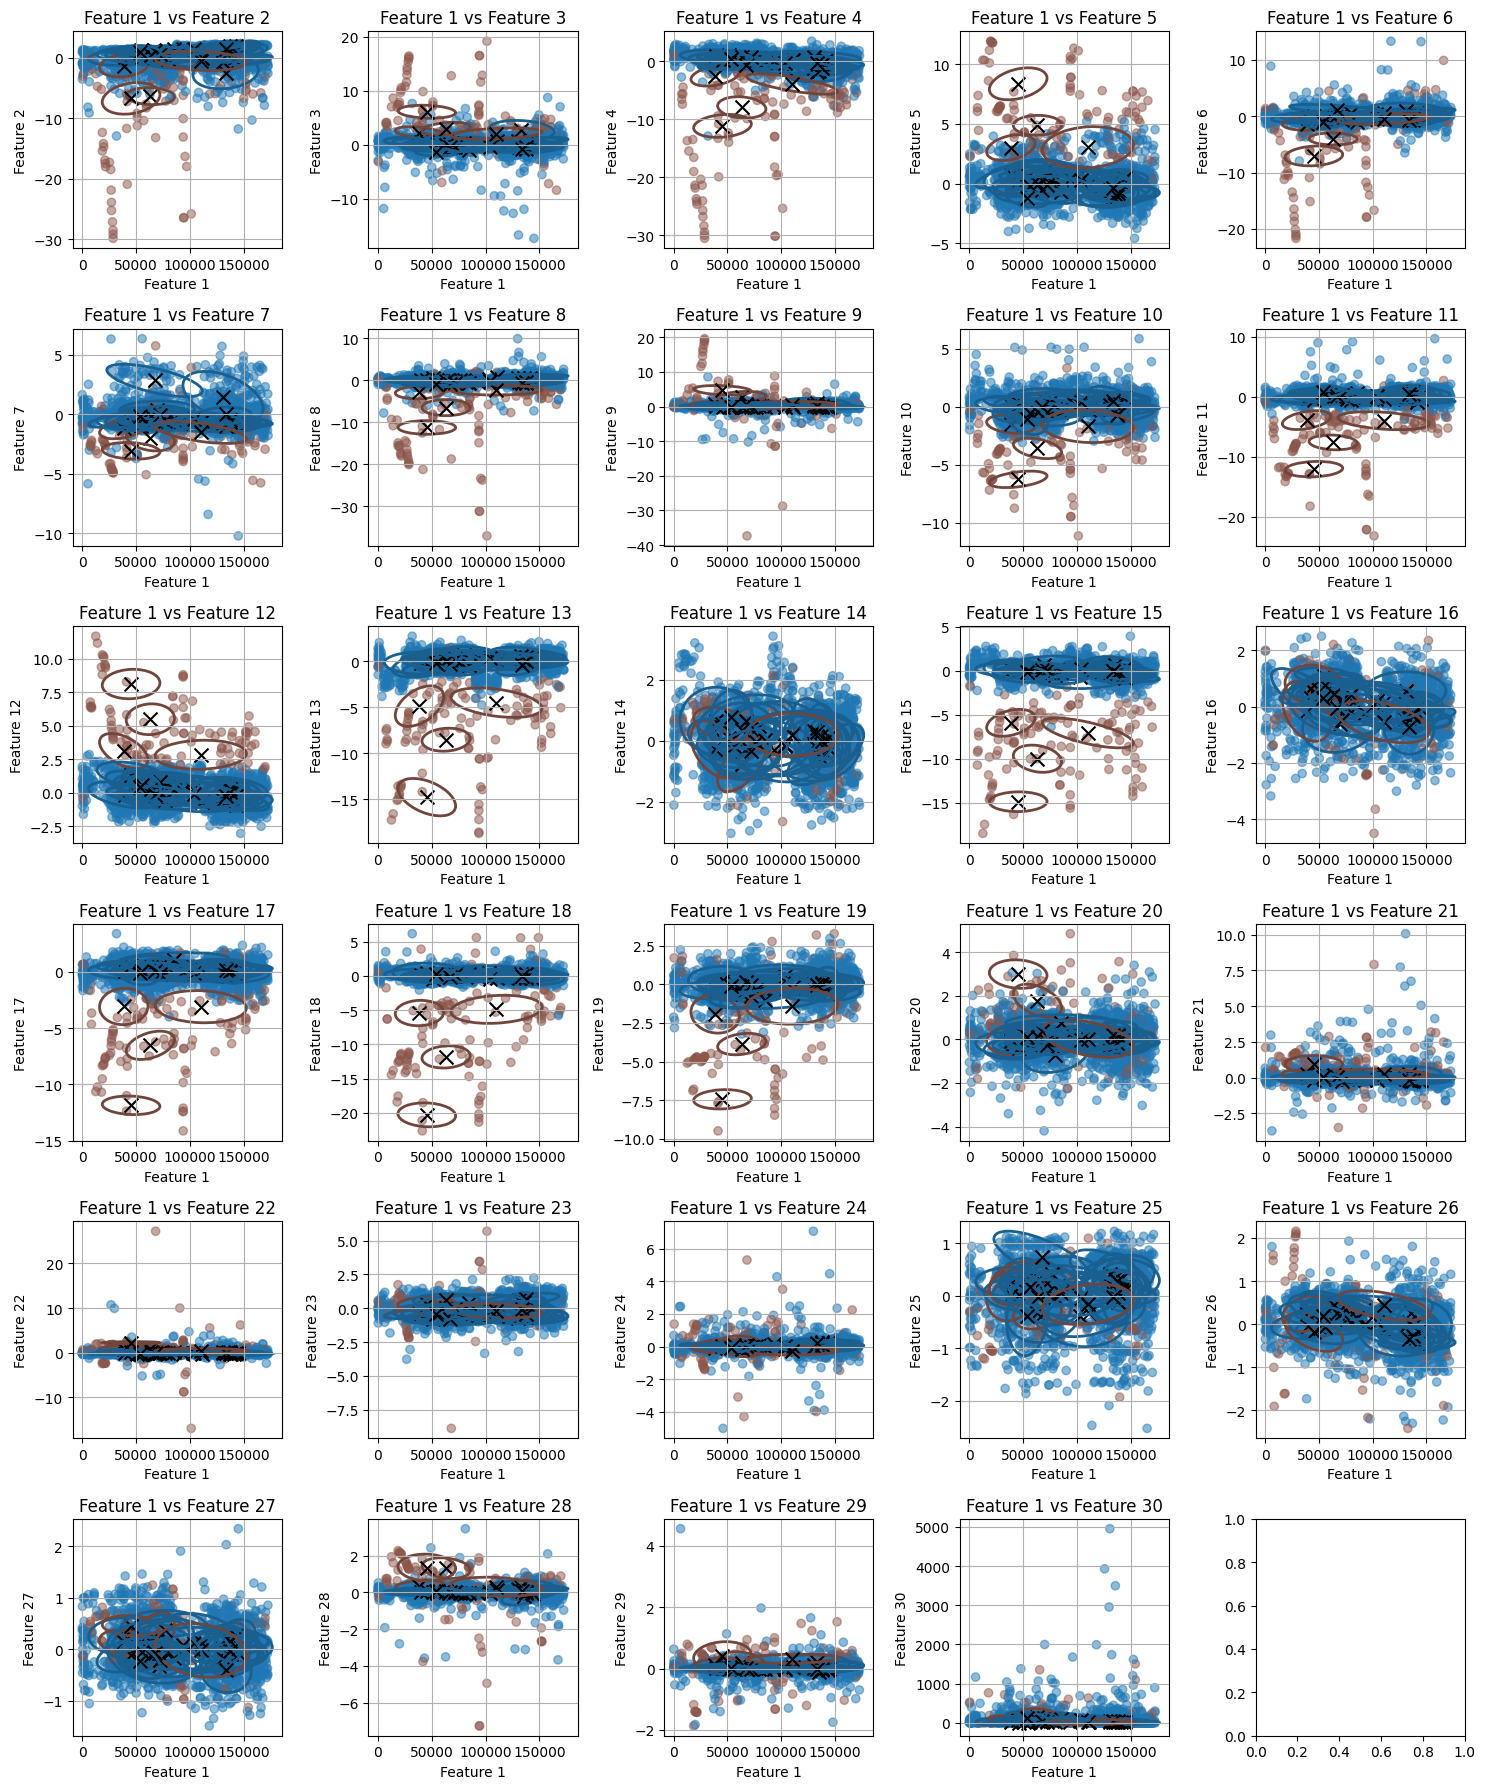

--- Communication Round 2 ---
Evolving has been enabled.
Evolving has been enabled.


In [10]:
# List of client counts and data configuration indices
client_counts = [3, 10]
data_config_indices = [2, 3]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 10
experiments = []
# Running the experiment
for num_clients in client_counts:
    for data_config_index in data_config_indices:
        if data_config_index == 1:
            proportion = 1
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 2:
            proportion = 10
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 3:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 

        display_dataset_split(client_train, test_data)

        print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
        metrics = run_experiment(num_clients, num_rounds, client_train, test_data)
        experiments.append(metrics)

In [ ]:
print("All Rounds Completed. Metrics Collected:")
for metric in metrics:
    print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
    print(f"                         Weighted: {metric['weighted']}")

In [ ]:
'''
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        #print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        #client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")
'''

In [ ]:
'''
federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")
'''

In [ ]:

'''
print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)
'''

In [ ]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''